## This is a Julia version of the code for Einstein_Scalar_field

See paper: *On free evolution of self gravitating, spherically symmetric waves.*

In [1]:
using OrdinaryDiffEq
using SummationByPartsOperators
#using DifferentialEquations
using Plots
using LinearAlgebra
#using BandedMatrices
using Printf


In [25]:
N = 4001 #grid steps
x_i = 1.0; x_f = 100.0 #region 
dx = (x_f-x_i)/(N-1)
U = 5 #number of fields (f,g,h,χ_+,χ_-)

u0 = zeros(N*U)
du = zeros(N*U)

D = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=4, xmin=x_i, xmax=x_f, N=N)

x = SummationByPartsOperators.grid(D)

Δ = dissipation_operator(D)
#Δ = 1.0
dT = 1.0*D.Δx
@show dx - D.Δx

dx - D.Δx = 0.0


0.0

In [3]:
function F!(du,u,p,t)
    # second order version
    D, Δ, x, dx, A, ω, τ, σ = p
    
    f = @view u[1:N]
    g = @view u[N+1:2N]
    h = @view u[2N+1:3N]
    χ₊ = @view u[3N+1:4N]
    χ₋ = @view u[4N+1:5N]

    df = @view du[1:N]
    dg = @view du[N+1:2N]
    dh = @view du[2N+1:3N]
    dχ₊ = @view du[3N+1:4N]
    dχ₋ = @view du[4N+1:5N]

    #= this is only the original system, (4) not the one we actually evolve!
    @. df = D*f 
    @. dg = D*g
    @. dh = D*h - df/2/f/x + (g-2)/2/f/h/x * dg - (g-f)*h/f/x -(g-2+f)/2/f/x^2 + 2*((χ₊ + χ₋)/f/x)^2 
    @. dg = -g/f * df + (f-2)/f * dg + 2g*h -g*(g-2+f)/f/x  
    @. df = df + (g-2+f)/x 
    @. dχ₊ = D*χ₊ - (f-2)* χ₋ /f/x
    @. dχ₋ = (f-2)/f * D*χ₋ 2χ₋ *(2x*(f-2)*h + 2 - g -f)/f^2/x + 8χ₋*(χ₊)^2/f^3/x - χ₊/x
    =#

    # these are the equations, (7)
    @. df = 2*(f-2)*h + 4* (χ₊)^2 /f/x
    @. dg = 2*g*h - 2g* (χ₊)^2 /f/x + 2g*(f-2)* (χ₋)^2/ f^2/x 
    
    #dh = D * h
    mul!(dh,D,h)
    #dh = D * h - σ*Δ * h
    @. dh = dh + (- (g-2)* (χ₊)^2 + 4χ₊*χ₋ + g* (χ₋)^2 ) /f^2/x^2
    dh[end] = dh[end] - 1.0/right_boundary_weight(D) *h[end] #penalty BC
    mul!(dh,Δ,h,-σ,true)

    #dχ₊ = D * χ₊
    mul!(dχ₊,D,χ₊) 
    #dχ₊ = D * χ₊ - σ*Δ * χ₊
    @. dχ₊ += - (f-2)* χ₋ /f/x
    dχ₊[end] = dχ₊[end] - 1.0/right_boundary_weight(D) * (χ₊[end] - A*sin(ω*t)*exp(-t/τ)) #penalty BC
    mul!(dχ₊,Δ,χ₊,-σ,true)

    #dχ₋ = D * χ₋
    mul!(dχ₋,D, χ₋)
    @. dχ₋ = (f-2)/f * dχ₋ + 2χ₋ *(2x*(f-2)*h + 2 - g -f)/f^2/x + 8χ₋*(χ₊)^2/f^3/x - χ₊/x
    
    if f[1]<2.0
        #dχ₋[1] += (f[1]-2)/f[1]/left_boundary_weight(D) *(χ₋[1] + χ₊[1]) #penalty BC
        dχ₋[1] += (f[1]-2)/f[1]/left_boundary_weight(D) * χ₋[1] #penalty BC
    end
    mul!(dχ₋,Δ,χ₋,-σ,true)

    #@. du = [df; dg; dh; dχ₊; dχ₋]
end

F! (generic function with 1 method)

In [26]:
# put some boundary data
A = 1.0; ω = 2π; τ = 5.0; σ = -0.1
p = (D, Δ, x, dx, A, ω, τ, σ)

f = @view u0[1:N]
g = @view u0[N+1:2N]
h = @view u0[2N+1:3N]
χ₊ = @view u0[3N+1:4N]
χ₋ = @view u0[4N+1:5N]

f .= 1.0;
g .= 1.0;
#rest set to zero

D*f

Δ*f

p

(SBP first-derivative operator of order 4 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., SBP 4-derivative dissipation operator of order 2 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Svärd, Nordström (2004) 
  Stable and Accurate Artificial Dissipation. 
  Journal of Scientific Computing 21.1, pp. 57-79. 
See also (first and second derivatives) 
  Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., 1.0:0.02475:100.0, 0.02475, 1.0, 6.283185307179586, 5.0, -0.1)

In [27]:
C = ones(2N)
function constraints!(C,u,D)
    x = SummationByPartsOperators.grid(D)
    N = length(x)
    f = @view u[1:N]
    g = @view u[N+1:2N]
    h = @view u[2N+1:3N]
    χ₊ = @view u[3N+1:4N]
    χ₋ = @view u[4N+1:5N]
    Cf = @view C[1:N]
    Cg = @view C[N+1:2N]
    #Cf = D * f
    mul!(Cf,D,f)
    #Cg = D * g
    mul!(Cg,D,g)
    @. Cf += - 2h*(f-2) + (g + f -2)/x - 4*(χ₊)^2/f/x 
    @. Cg += - 2g*(h*f*x - (χ₊)^2 + (χ₋)^2)/f/x
    #C = [Cf;Cg]
end



constraints! (generic function with 1 method)

In [28]:
T=200
prob = ODEProblem(F!,u0,(0.0,T),p);
sol = solve(prob,RK4(),dt=dT,adaptive=false);#,save_everystep=false);

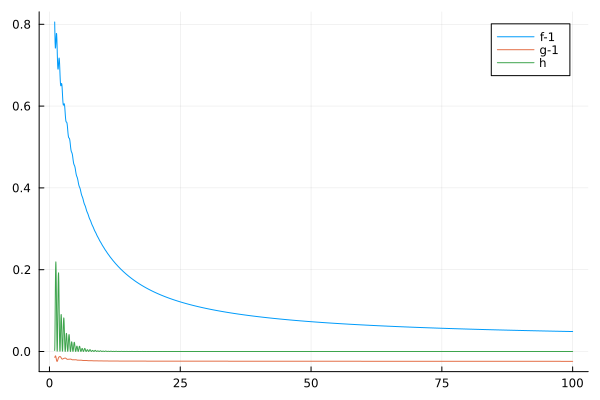

In [29]:
t = 100
plot(x,sol(t)[1:N].-1.0, label = "f-1")
plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
plot!(x,sol(t)[2N+1:3N], label = "h")

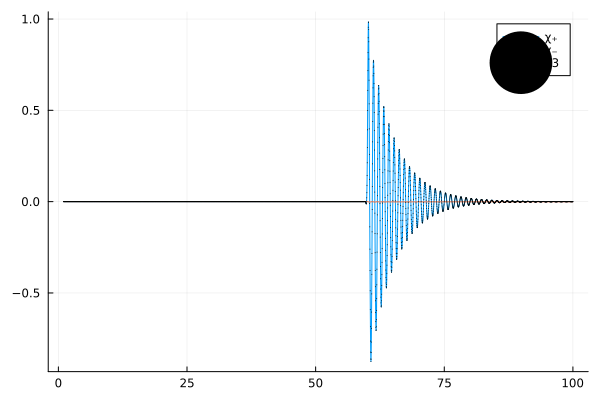

In [30]:
t = 40
plot(x,sol(t)[3N+1:4N], label = "χ₊")
plot!(x,sol(t)[4N+1:5N], label = "χ₋")
scatter!(x,sol(t)[3N+1:4N],ms=0.1)

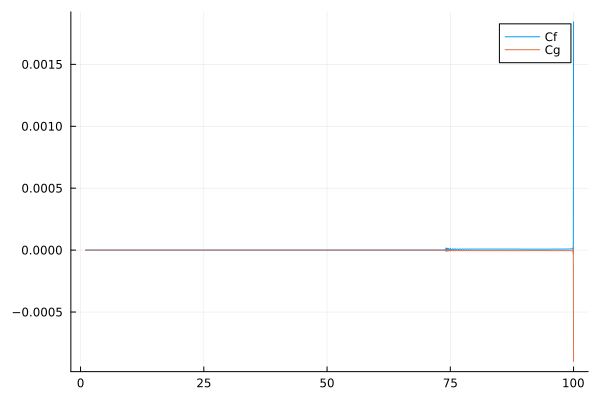

In [31]:
t = 26
constraints!(C,sol(t),D)
plot(x,C[1:N], label = "Cf")
plot!(x,C[N+1:2N], label = "Cg")

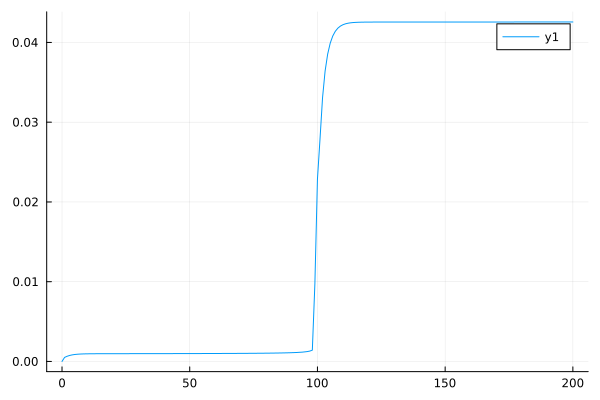

In [32]:
CC(t) = norm(constraints!(C,sol(t),D))
plot(0:T,t->CC(t))

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/fgh_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/fgh_fps5.gif")
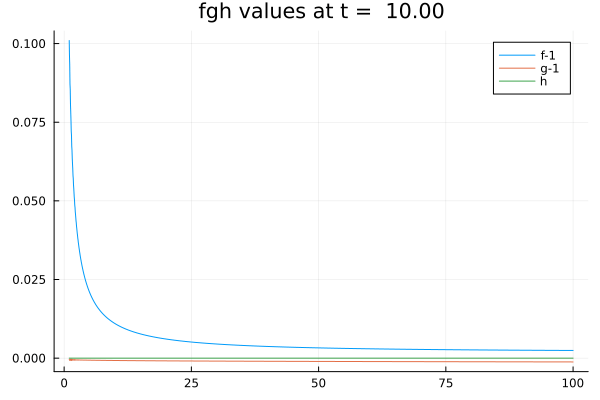

In [16]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title=@sprintf("fgh values at t = %6.2f",t))
    #@sprintf("\$t = %6.2f \$", sol.t[idx])
    plot!(x,sol(t)[1:N].-1.0, label = "f-1")
    plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
    plot!(x,sol(t)[2N+1:3N], label = "h")
end

gif(anim, "fgh_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif")
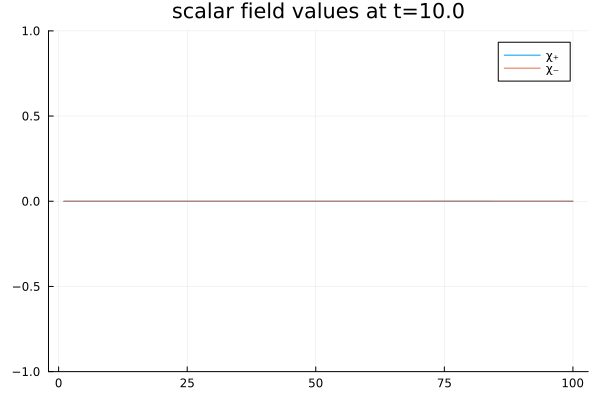

In [17]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="scalar field values at t=$t", ylim=(-1,1))
    plot!(x,sol(t)[3N+1:4N], label = "χ₊")
    plot!(x,sol(t)[4N+1:5N], label = "χ₋")
end

gif(anim, "scalar_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif")
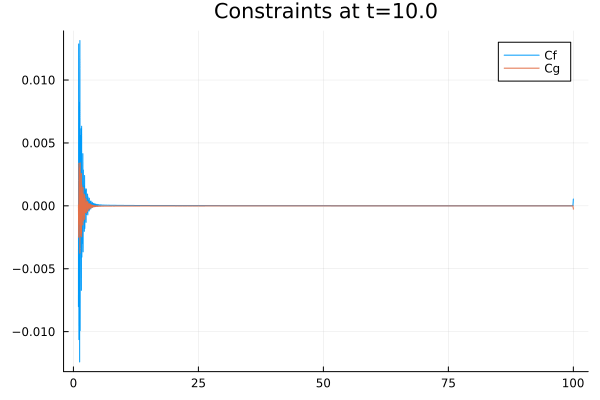

In [18]:
C = zeros(2N)
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="Constraints at t=$t")#, ylim=(-1,1))
    constraints!(C,sol(t),D)
    plot!(x,C[1:N], label = "Cf")
    plot!(x,C[N+1:2N], label = "Cg")
end

gif(anim, "scalar_fps5.gif", fps = 5)

In [14]:
D1 = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=2, xmin=0, xmax=1, N=3)
left_boundary_weight(D1)

0.25

In [15]:
D4 = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=4, xmin=0, xmax=1, N=3)
left_boundary_weight(D4)*2*48/17

DimensionMismatch: DimensionMismatch: length(grid) > LowerOffset + UpperOffset must hold. Got
length(grid) => 3
LowerOffset + UpperOffset => 4

In [16]:
a = [1,2]
b = @view a[:]
b .= [3,4]
a

2-element Vector{Int64}:
 3
 4

In [17]:
a = [1,2]
b = a
b .= [3,4]


2-element Vector{Int64}:
 3
 4

In [18]:
a

2-element Vector{Int64}:
 3
 4